In [3]:
from tabpfn.scripts.transformer_prediction_interface import TabPFNClassifier
from create_model import load_model_no_train


In [2]:
device = "cuda:3"
#checkpoint = "linear12903_50"
#checkpoint = "linear77575_fxj5a68i_390"
checkpoint = "linear69376_okcpk2bv_170"
model = TabPFNClassifier(device=device)#, no_preprocess_mode=True)
#model = GradientBoostingClassifier()
config = model.c
config["num_features"] = 10
model_pytorch = load_model_no_train("tabpfn/model_checkpoints", f"model_{checkpoint}.pt", 0, config, 0)[0]
model.max_num_features = 10
model.model = model_pytorch

Using style prior: True
{'recompute_attn': True}
Using cuda:3 device
Batch size: 1
DataLoader.__dict__ {'num_features': 100, 'num_steps': 8192, 'batch_size': 1, 'eval_pos_seq_len_sampler': <function create_model.<locals>.eval_pos_seq_len_sampler at 0x7f2bf4fda1f0>, 'seq_len_maximum': 10, 'device': 'cuda:3', 'get_batch_kwargs': {'hyperparameters': {'lr': 0.0001, 'dropout': 0.0, 'emsize': 512, 'batch_size': 1, 'nlayers': 12, 'num_features': 100, 'nhead': 4, 'nhid_factor': 2, 'bptt': 10, 'eval_positions': [972], 'seq_len_used': 50, 'sampling': 'mixed', 'epochs': 400, 'num_steps': 8192, 'verbose': False, 'mix_activations': True, 'nan_prob_unknown_reason_reason_prior': 1.0, 'categorical_feature_p': 0.2, 'nan_prob_no_reason': 0.0, 'nan_prob_unknown_reason': 0.0, 'nan_prob_a_reason': 0.0, 'max_num_classes': 10, 'num_classes': 2, 'noise_type': 'Gaussian', 'balanced': False, 'normalize_to_ranking': False, 'set_value_to_nan': 0.1, 'normalize_by_used_features': True, 'num_features_used': <functio

In [7]:
import pandas as pd
# import train_test_split
from sklearn.model_selection import train_test_split

df = pd.read_csv("tabpfn/prostate.csv")

In [8]:
X, y = df.drop(columns=["y"]), df["y"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
X_train = X_train[X_train.columns[:5000]]
X_test = X_test[X_test.columns[:5000]]

In [15]:
model.fit(X_train, y_train)

TabPFNClassifier(device='cuda:3')

In [16]:
# compute accuracy
model.score(X_test, y_test)

interface
torch.Size([102, 1, 5000])
torch.Size([102, 1])
81


0.42857142857142855

In [17]:
model.predict(X_test)

interface
torch.Size([102, 1, 5000])
torch.Size([102, 1])
81


array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1])

In [19]:
model.predict_proba(X_test)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 6033 and the array at index 1 has size 10000

In [18]:
# Synthetic high dimensional data
import numpy as np
X = np.random.rand(100, 3000)
number_of_relevant_features = 50
relevant_features = np.random.choice(3000, number_of_relevant_features, replace=False)
W = np.random.rand(number_of_relevant_features, 1)
y = np.dot(X[:, relevant_features], W)
y = (y > np.median(y)).astype(int).flatten()


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
model.predict(X_test)

interface
torch.Size([100, 1, 3000])
torch.Size([100, 1])
80


array([1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0])

In [77]:
from tabpfn.priors.linear import get_batch
from tabpfn.priors.flexible_categorical import MulticlassRank, BalancedBinarize

def get_batch_func():
    hyperparameters = {"random_feature_removal": 0.00, "random_feature_removal_min":0.00,
                    "correlation_strength_min": 0, "correlation_strength_max": 0,
                    "correlation_proba_min": 0, "correlation_proba_max": 0,
                    "p_categorical": 0,
                    "sampling": "normal",
                    "output_multiclass_ordered_p": 0.0,
    }
                    
    X, y, _ = get_batch(batch_size=1,
            seq_len=1200,
            num_features=10,
            hyperparameters=hyperparameters)

    class_assigner = MulticlassRank(num_classes=2, ordered_p=hyperparameters["output_multiclass_ordered_p"])
    #class_assigner = BalancedBinarize()
    y = class_assigner(y)
    X = X.reshape(X.shape[0], X.shape[2])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
    return X_train, X_test, y_train, y_test

In [78]:
res_tabpfn

[0.986268740367101,
 0.9902854474581777,
 0.9943916497896869,
 0.9545454545454546,
 0.999290780141844,
 0.9922846782282192,
 0.9994110718492344,
 0.986842105263158,
 0.9117647058823529,
 0.9948982468008343,
 0.9930298042792838,
 0.9949395842587334,
 0.9545454545454546,
 0.9850518276050191,
 0.9595904095904096]

In [79]:
from sklearn.metrics import balanced_accuracy_score
clf_lasso = LogisticRegression(random_state=0, penalty="l1", solver="saga", max_iter=1000)
clf_l2 = LogisticRegression(random_state=0, penalty="l2", max_iter=1000)
gbt = GradientBoostingClassifier()

In [80]:
n_iter = 15
res_tabpfn = []
res_lasso = []
res_linear = []
res_gbt = []
for _ in range(n_iter):
    X_train, X_test, y_train, y_test = get_batch_func()
    model.fit(X_train, y_train)
    clf_lasso.fit(X_train, y_train)
    clf_l2.fit(X_train, y_train)
    gbt.fit(X_train, y_train)
    res_tabpfn.append(balanced_accuracy_score(y_test, model.predict(X_test)))
    res_lasso.append(balanced_accuracy_score(y_test, clf_lasso.predict(X_test)))
    res_linear.append(balanced_accuracy_score(y_test, clf_l2.predict(X_test)))
    res_gbt.append(balanced_accuracy_score(y_test, gbt.predict(X_test)))

/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/ens

interface
torch.Size([1200, 1, 10])
torch.Size([1200, 1])
600


/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/ens

interface
torch.Size([1200, 1, 10])
torch.Size([1200, 1])
600


/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/ens

interface
torch.Size([1200, 1, 10])
torch.Size([1200, 1])
600


/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/ens

interface
torch.Size([1200, 1, 10])
torch.Size([1200, 1])
600


/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/ens

interface
torch.Size([1200, 1, 10])
torch.Size([1200, 1])
600


/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/ens

interface
torch.Size([1200, 1, 10])
torch.Size([1200, 1])
600


/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/ens

interface
torch.Size([1200, 1, 10])
torch.Size([1200, 1])
600


/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/ens

interface
torch.Size([1200, 1, 10])
torch.Size([1200, 1])
600


/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/ens

interface
torch.Size([1200, 1, 10])
torch.Size([1200, 1])
600


/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/ens

interface
torch.Size([1200, 1, 10])
torch.Size([1200, 1])
600


/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/ens

interface
torch.Size([1200, 1, 10])
torch.Size([1200, 1])
600


/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/ens

interface
torch.Size([1200, 1, 10])
torch.Size([1200, 1])
600


/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/ens

interface
torch.Size([1200, 1, 10])
torch.Size([1200, 1])
600


/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/ens

interface
torch.Size([1200, 1, 10])
torch.Size([1200, 1])
600


/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/ens

interface
torch.Size([1200, 1, 10])
torch.Size([1200, 1])
600


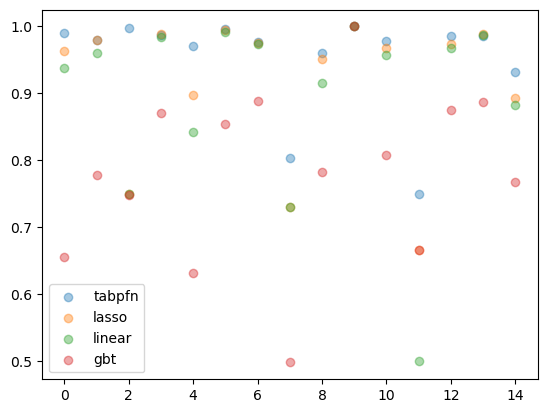

In [81]:
import matplotlib.pyplot as plt
plt.scatter(range(n_iter), res_tabpfn, label="tabpfn", alpha=0.4)
plt.scatter(range(n_iter), res_lasso, label="lasso", alpha=0.4)
plt.scatter(range(n_iter), res_linear, label="linear", alpha=0.4)
plt.scatter(range(n_iter), res_gbt, label="gbt", alpha=0.4)
plt.legend()

In [38]:
res_lasso

[0.9953703703703703,
 0.9908536585365854,
 1.0,
 0.9899749373433584,
 1.0,
 0.986842105263158,
 1.0,
 0.875,
 0.875,
 0.9,
 0.9969325153374233,
 1.0,
 0.9964285714285714,
 0.9862938596491229,
 0.9714285714285714]

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X.shape

torch.Size([1000, 1, 10])

In [17]:
X = X.reshape(X.shape[0], X.shape[2])


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [19]:
model.fit(X_train, y_train)

/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TabPFNClassifier(device='cuda:3')

In [20]:
model.score(X_test, y_test)

interface
torch.Size([1000, 1, 10])
torch.Size([1000, 1])
800


0.995

In [21]:
model.predict(X_test)

interface
torch.Size([1000, 1, 10])
torch.Size([1000, 1])
800


array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [22]:
import torch
import numpy as np
# Baselines
# Predict the most common class
most_common_class = np.bincount(y_train.reshape(-1)).argmax()
print(f"Accuracy: {torch.sum(y_test == most_common_class) / len(y_test)}")

least_common_class = np.bincount(y_train.reshape(-1)).argmin()
print(f"Accuracy: {torch.sum(y_test == least_common_class) / len(y_test)}")


Accuracy: 0.8799999952316284
Accuracy: 0.11999999731779099


In [23]:
# Lasso for classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
#clf = GradientBoostingClassifier().fit(X_train, y_train)
clf = LogisticRegression(random_state=0, penalty="l1", solver="saga", max_iter=1000).fit(X_train, y_train)
clf.score(X_test, y_test)

/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.995

0.97

In [2]:
import scipy

In [4]:
import time
import numpy as np

In [27]:
start = time.time()
for i in range(10):
    normal = scipy.stats.norm.rvs(loc=0, scale=1, size=(1000, 1, 10000), random_state=None)
print(time.time() - start)

8.077756643295288


In [7]:
start = time.time()
for i in range(1):
    normal = np.random.normal(loc=0, scale=1, size=(1000, 1, 10000))
print(time.time() - start)

0.5950906276702881


In [12]:
from numba import njit

@njit(parallel=True)
def generate_random_values(shape):
    return np.random.normal(0, 1, shape)

# Call the function once to compile it
_ = generate_random_values((1, 1))

# Now you can use the optimized function
random_values = generate_random_values((1000, 10000))

In [28]:
start = time.time()
for i in range(10):
    random_values = generate_random_values((1000, 1, 10000))
print(time.time() - start)

1.1224868297576904


In [30]:
import torch

In [39]:
start = time.time()
torch.normal(mean=torch.zeros(1000, 10, 10000), std=torch.ones(1000, 10, 10000))
print(time.time() - start)

1.2172961235046387


In [ ]:
from tabpfn.priors.trees import get_batch
from tabpfn.priors.flexible_categorical import MulticlassRank, BalancedBinarize, MulticlassValue
import numpy as np

hyperparameters = {"n_estimators_lambda": 0.15, "max_depth_lambda": 0.35,
                   "n_estimators": None,
                   "num_classes": 10,
                   "randomize_leaves": False,
                   "return_classes": False,
                   "correlation_strength_min": 0, "correlation_strength_max": 0,
                   "correlation_proba_min": 0, "correlation_proba_max": 0,
                   "p_categorical": 0,
                   "sampling": "normal",
                   "output_multiclass_ordered_p": 0.0,
}
                   
X, y, _ = get_batch(batch_size=1,
          seq_len=1000,
          num_features=2,
          hyperparameters=hyperparameters)

# normalize y
y = (y - y.min()) / (y.std())
class_assigner = MulticlassRank(num_classes=10, ordered_p=hyperparameters["output_multiclass_ordered_p"])
#class_assigner = MulticlassValue(num_classes=hyperparameters["num_classes"])
#class_assigner = BalancedBinarize()
y = class_assigner(y)

10 2
0.0


In [ ]:
import numpy as np
np.unique(y, return_counts=True)

(array([0, 1]), array([381, 619]))

In [ ]:
X

tensor([[[ 0.6092,  0.1397]],

        [[ 0.4390, -0.6159]],

        [[-1.0634,  0.1834]],

        ...,

        [[ 0.2965, -1.2584]],

        [[-0.8430,  0.2685]],

        [[-0.8229, -1.7594]]])

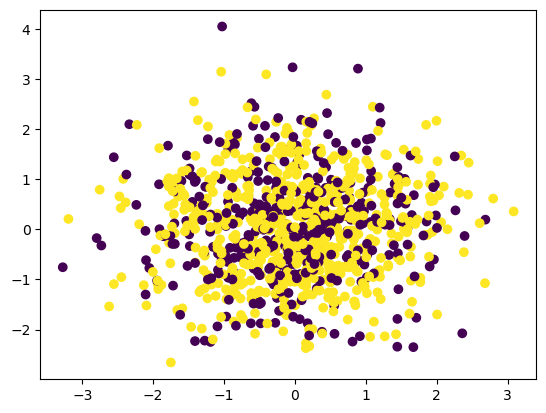

In [ ]:
import matplotlib.pyplot as plt
X = X.reshape(X.shape[0], X.shape[2])
plt.scatter(X[:, 0], X[:, 1], c=y)